In [ ]:
# import pytorch libraries
import torch
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
# download and set up the data
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307), (0.3081))]) # normalise data with mean=0.1307 std=0.3081

trainset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=0)

testset = torchvision.datasets.MNIST(root='./data', train=False, transform=transform, download=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=1000, shuffle=False, num_workers=0)

classes = ('0','1','2','3','4','5','6','7','8','9')

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)




torch.Size([64, 1, 28, 28])
torch.Size([64])
0


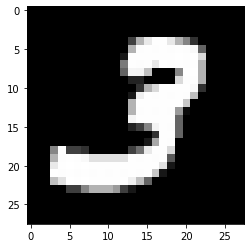

3


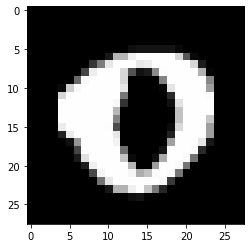

0


In [ ]:
import matplotlib.pyplot as plt
examples = enumerate(trainloader)
batch_idx, (example_data, example_targets) = next(examples)
print(example_data.shape)
print(example_targets.shape)
print(batch_idx)
plt.imshow(example_data[0,0], cmap='Greys_r', vmin=example_data[0,0].min(), vmax=example_data[0,0].max())
plt.show()
print(classes[example_targets[0]])
plt.imshow(example_data[1,0], cmap='Greys_r', vmin=example_data[0,0].min(), vmax=example_data[0,0].max())
plt.show()
print(classes[example_targets[1]])
# can see that first index of [a,b] i.e. a details the number in the batch

In [ ]:
# define your neural network model
class neural_net(nn.Module):
  def __init__(self):
    super(neural_net,self).__init__()
    self.conv1 = nn.Conv2d(1,6,3) # i.e. 1 input channel (grayscale), 6 output channels (features), 3x3 Kernel
    self.pool = nn.MaxPool2d(2,2) # define pool as max 2x2
    self.conv2 = nn.Conv2d(6,16,3)
    self.fc1 = nn.Linear(in_features = 16*5*5, out_features = 64) # pool
    self.fc2 = nn.Linear(in_features = 64, out_features = 64)
    self.out = nn.Linear(in_features = 64, out_features = 10)
  def forward(self,x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = x.view(-1,16*5*5)  
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.out(x)
    return x

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = neural_net()
model.to(device)

neural_net(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (out): Linear(in_features=64, out_features=10, bias=True)
)

In [ ]:
from torchsummary import summary
data_input_shape = (1,28,28)
summary(model, data_input_shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 26, 26]              60
         MaxPool2d-2            [-1, 6, 13, 13]               0
            Conv2d-3           [-1, 16, 11, 11]             880
         MaxPool2d-4             [-1, 16, 5, 5]               0
            Linear-5                   [-1, 64]          25,664
            Linear-6                   [-1, 64]           4,160
            Linear-7                   [-1, 10]             650
Total params: 31,414
Trainable params: 31,414
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.06
Params size (MB): 0.12
Estimated Total Size (MB): 0.18
----------------------------------------------------------------


In [ ]:
# define the loss criterion and optimizer
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(),lr = 0.001, momentum = 0.9)


In [ ]:
# implement the training loop
for epoch in range(3):
  running_loss = 0.0  
  for i, data in enumerate(trainloader,0):
    # i is is counting the sets of images of batch size 64 in the training set
    # gets the data from train loader, where data = [images, labels]
    inputs, labels = data[0].to(device), data[1].to(device)
    optimizer.zero_grad()

    # forward + backward + optimize
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step() # does the update

    # print statistics
    running_loss += loss.item() 
    if i % 100 == 99: # print every 2000 minibatches
      print('[%d,%5d] loss for this batch of 2000 sets of 64 images is: %.3f' % (epoch + 1, i + 1 , running_loss/2000))
      running_loss = 0
      # i.e. running loss is for each 2000 sets of 64 images

print('Finished Training')


[1,  100] loss for this batch of 2000 sets of 64 images is: 0.114
[1,  200] loss for this batch of 2000 sets of 64 images is: 0.112
[1,  300] loss for this batch of 2000 sets of 64 images is: 0.098
[1,  400] loss for this batch of 2000 sets of 64 images is: 0.055
[1,  500] loss for this batch of 2000 sets of 64 images is: 0.033
[1,  600] loss for this batch of 2000 sets of 64 images is: 0.025
[1,  700] loss for this batch of 2000 sets of 64 images is: 0.020
[1,  800] loss for this batch of 2000 sets of 64 images is: 0.018
[1,  900] loss for this batch of 2000 sets of 64 images is: 0.015
[2,  100] loss for this batch of 2000 sets of 64 images is: 0.013
[2,  200] loss for this batch of 2000 sets of 64 images is: 0.013
[2,  300] loss for this batch of 2000 sets of 64 images is: 0.013
[2,  400] loss for this batch of 2000 sets of 64 images is: 0.011
[2,  500] loss for this batch of 2000 sets of 64 images is: 0.010
[2,  600] loss for this batch of 2000 sets of 64 images is: 0.010
[2,  700] 

Save the model

In [ ]:
# PATH = 'C:/Users/oliver/Google Drive/Physics - Manc/Fourth Year/MPhys/Python'
# torch.save(model.state_dict(), PATH)

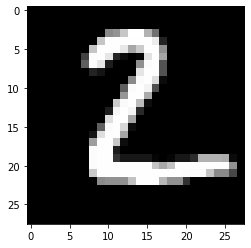

tensor(2)


In [ ]:
# implement a function to test the model on the unseen test data

# print out one number from test batch
test_examples = enumerate(testloader)
testbatch_idx, (test_data, test_targets) = next(test_examples)

plt.imshow(test_data[1][0], cmap = 'Greys_r', vmin = test_data[0][0].min(), vmax = test_data[0][0].max())
plt.show()
print(test_targets[1])

In [ ]:
# Lets see what model thinks - Outputs are 'probabilities' therefore lets find index of highest probablity
outputs = model(test_data)
_ , predicted = torch.max(outputs,1) # empty string contains values of probabilities
# predicted is a tensor containining the index of the classes

# First print out actual labels
print('The actual labels are:\n')
print(''.join('%5d' % test_targets[j] for j in range(64)))

# Then print out predicted
print('The predicted labels are:\n')
print(''.join('%5s' % classes[predicted[k]] for k in range(64)))



RuntimeError: ignored

Look at how it peforms on whole dataset

In [ ]:
correct = 0
total = 0

with torch.no_grad(): # i.e. no point wasting time calculating gradient don't need it here
  for data in testloader: # i.e. iterate over batches of data in the test set
    images, labels = data # each data is a batch of 64 images and their labels, comma here splits it up accordingly
    outputs = model(images) # run the model with the test batch file of 64 images
    _, predicted = torch.max(outputs.data, 1) # predicted is tensor containing indices of predicted classes
    total += labels.size(0) # .size(0) gives the number of rows, .size(1) gives the number of columns
    # here labels is a tensor of size 64, correspondning to 64 images
    # therefore each run of loop adds 64 images that have been analysed
    correct += (predicted == labels).sum().item() # this adds up total number of correct predictions in this batch of 64

print('Accuracy of the model of 60,000 images: %d %%' % (100 * correct/total))


[[ 973    0    1    0    0    3    0    1    2    0]
 [   0 1123    4    1    0    0    2    0    5    0]
 [   8    0  996    6    3    1    2    8    8    0]
 [   1    0   10  962    0   16    0    7   13    1]
 [   1    0    1    0  963    0    3    1    2   11]
 [   4    1    0    5    0  876    2    1    2    1]
 [  12    3    1    0    3    9  929    0    1    0]
 [   1    4   16    1    0    2    0  997    3    4]
 [  12    1    6    5    5   10    4    7  921    3]
 [  10    6    2    4   10    7    0    9    6  955]]


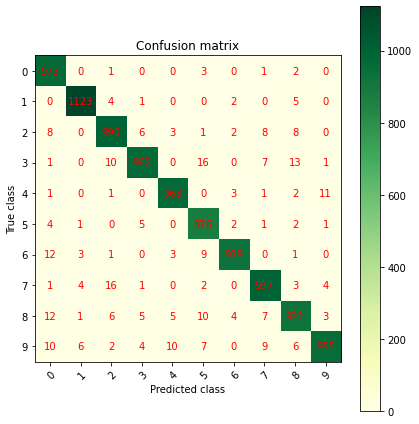

Class | Class Accuracy
0 | 99.28571428571429
1 | 98.94273127753304
2 | 96.51162790697674
3 | 95.24752475247524
4 | 98.06517311608961
5 | 98.20627802690584
6 | 96.97286012526096
7 | 96.98443579766537
8 | 94.55852156057495
9 | 94.64816650148661


In [ ]:
# confusion matrix

#model_save_name = 'model_best_on_val.pt'
#path = F"/content/gdrive/My Drive/Week 3/{model_save_name}"
#model.load_state_dict(torch.load(path))

# plot confusion matrix
number_classes = 10

from matplotlib.pyplot import figure

from sklearn.metrics import confusion_matrix
import numpy as np

# initialise prediction and label lists(tensors)
predlist=torch.zeros(0,dtype=torch.long, device='cuda')
lbllist=torch.zeros(0,dtype=torch.long, device='cuda')

with torch.no_grad(): # i.e. no point wasting time calculating gradient don't need it here
  for data in testloader: # i.e. iterate over batches of data in the test set
    images, labels = data[0].to(device), data[1].to(device)
    outputs = model(images) # run the model with the test batch file of 64 images
    _, predicted = torch.max(outputs, 1) # predicted is tensor containing indices of predicted classes

with torch.no_grad():
  for data in testloader:
    images, labels = data[0].to(device), data[1].to(device)
    outputs = model(images)
    _, predicted = torch.max(outputs, 1) # predicted is tensor containing indices of predicted classes
    # Append batch prediction results
    predlist=torch.cat([predlist,predicted.view(-1).to(device)])
    lbllist=torch.cat([lbllist,labels.view(-1).to(device)])

# Confusion matrix
predlist = predlist.cpu()
lbllist = lbllist.cpu()
conf_mat=confusion_matrix(lbllist.numpy(), predlist.numpy())
conf_mat = np.array(conf_mat)
print(conf_mat)

fig, ax = plt.subplots(figsize=(6,6))
im = ax.imshow(conf_mat, cmap="YlGn")


# We want to show all ticks...
ax.set_xticks(np.arange(len(classes)))
ax.set_yticks(np.arange(len(classes)))
# ... and label them with the respective list entries
ax.set_xticklabels(classes)
ax.set_yticklabels(classes)
plt.xlabel('Predicted class')
plt.ylabel('True class')

# Create colorbar
cbar = ax.figure.colorbar(im, ax=ax, cmap="YlGn")
cbar.ax.set_ylabel('', rotation=-90, va="bottom")

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# Loop over data dimensions and create text annotations 
for i in range(len(classes)):
    for j in range(len(classes)):
        text = ax.text(j, i, conf_mat[i, j], ha="center", va="center", color="r")

ax.set_title("Confusion matrix")
fig.tight_layout()
plt.show()

# Per-class accuracy
class_accuracy=100*conf_mat.diagonal()/conf_mat.sum(1)
print('Class' + ' | ' + 'Class Accuracy')
for i in range(len(classes)):
  print(classes[i] + ' | ' + str(class_accuracy[i]))

